In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import copy
from google.colab import drive
import zipfile
import pandas as pd
import cv2
import numpy as np
import albumentations as A

In [ ]:
import zipfile
from google.colab import drive
import os
import pandas as pd
import numpy as np
 
 
drive.mount('/content/drive')
 
zip_file = '/content/drive/MyDrive/KedyKrossyDataset.zip'
z = zipfile.ZipFile(zip_file,'r')
z.extractall()

Mounted at /content/drive


In [ ]:
SIZE = 128

In [ ]:
def show_image(img):
    img = np.transpose(img, (1, 2, 0)).astype(np.float32) * 255
    plt.imshow(img.astype(np.uint8))
    plt.show()

def load_image(fname, start = 0, stop = 10):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

In [ ]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(-90, 90)),
    A.VerticalFlip(p=0.5),
    ], p=1.)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, dirname, augmentation, flag_train = False, k_size = 0.8):
        self.flag_train = flag_train
        self.augmentation = augmentation
        self.dirname = dirname
        self.flag_train = flag_train
        fname_list1 = sorted([dirname + '/kedy/' + s for s in os.listdir(dirname + '/kedy')])
        fname_list2 = sorted([dirname + '/krossy/' + s for s in os.listdir(dirname + '/krossy')])
        if self.flag_train:
            self.fname_list = fname_list1[:int(len(list(fname_list1))*k_size)] + fname_list2[:int(len(list(fname_list2))*k_size)]
        else:
            self.fname_list = fname_list1[int(len(list(fname_list1))*(1 - k_size)):] + fname_list2[int(1 - len(list(fname_list2))*(1 - k_size)):]
        
    def __len__(self):
        return len(self.fname_list)
    
    def __getitem__(self, item):
        image = load_image(self.fname_list[item])
        image = cv2.resize(image, (128, 128))
        

        if self.flag_train:
            augmented = self.augmentation(image=image)
            image = augmented["image"]
            
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)/255.0

        
        return torch.tensor(image, dtype=torch.float), torch.tensor(image, dtype=torch.float)

In [ ]:

class Encoder(nn.Module):
    '''encoder for VAE, goes from image conv net to linear latent layer'''
    def __init__(self, size, z_dim):
        super(Encoder, self).__init__()
        self.size = size
        self.z_dim = z_dim 
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv1_1 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 2, padding = 1)
        self.conv2_1 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_1 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 2, padding = 1)
        self.conv4_1 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 2, padding = 1)
        self.conv5_1 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        #self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 2, padding = 1)
        #self.conv6_1 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)

        self.batch_normal1 = nn.BatchNorm2d(32)
        self.batch_normal2 = nn.BatchNorm2d(64)
        self.batch_normal3 = nn.BatchNorm2d(128)
        self.batch_normal4 = nn.BatchNorm2d(256)
        self.batch_normal5 = nn.BatchNorm2d(512)
        #self.batch_normal6 = nn.BatchNorm2d(256)

        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout2d(0.25)
        self.dropout4 = nn.Dropout2d(0.25)
        self.dropout5 = nn.Dropout2d(0.25)
        self.dropout6 = nn.Dropout2d(0.25)

        self.fc_mu = nn.Linear(in_features = (self.size//32)**2*512, out_features = z_dim)
        self.fc_logvar = nn.Linear(in_features = (self.size//32)**2*512, out_features = z_dim)

    def forward(self, x):
        x = F.leaky_relu(self.batch_normal1(self.conv1_1(self.conv1(x))))
        x = self.dropout1(x)
        x = F.leaky_relu(self.batch_normal2(self.conv2_1(self.conv2(x))))
        x = self.dropout2(x)
        x = F.leaky_relu(self.batch_normal3(self.conv3_1(self.conv3(x))))
        x = self.dropout3(x)
        x = F.leaky_relu(self.batch_normal4(self.conv4_1(self.conv4(x))))
        x = self.dropout4(x)
        x = F.leaky_relu(self.batch_normal5(self.conv5_1(self.conv5(x))))
        x = self.dropout5(x)
        #x = F.leaky_relu(self.batch_normal6(self.conv6_1(self.conv6(x))))
        #x = self.dropout6(x)

        x = x.view(x.size(0), -1) # flatten feature maps
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    '''decoder for VAE, goes from linear latent layer to deconv layers to reconstruct image'''
    def __init__(self, size, z_dim):
        super(Decoder, self).__init__()
        self.size = size
        self.z_dim = z_dim 
        self.fc = nn.Linear(in_features = z_dim, out_features = (size//32)**2*512)
        self.conv1 = nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size=4, stride=2, padding=1)
        self.conv1_1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.ConvTranspose2d(out_channels = 32, in_channels = 64, kernel_size = 4, stride = 2, padding = 1)
        self.conv2_1 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.ConvTranspose2d(out_channels = 64, in_channels = 128, kernel_size = 4, stride = 2, padding = 1)
        self.conv3_1 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.ConvTranspose2d(out_channels = 128, in_channels = 256, kernel_size = 4, stride = 2, padding = 1)
        self.conv4_1 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.ConvTranspose2d(out_channels = 256, in_channels = 512, kernel_size = 4, stride = 2, padding = 1)
        self.conv5_1 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        #self.conv6 = nn.ConvTranspose2d(out_channels = 128, in_channels = 256, kernel_size = 4, stride = 2, padding = 1)
        #self.conv6_1 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)

        self.batch_normal1 = nn.BatchNorm2d(3)
        self.batch_normal2 = nn.BatchNorm2d(32)
        self.batch_normal3 = nn.BatchNorm2d(64)
        self.batch_normal4 = nn.BatchNorm2d(128)
        self.batch_normal5 = nn.BatchNorm2d(256)
        #self.batch_normal6 = nn.BatchNorm2d(128)

        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout2d(0.25)
        self.dropout4 = nn.Dropout2d(0.25)
        self.dropout5 = nn.Dropout2d(0.25)
        self.dropout6 = nn.Dropout2d(0.25)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 512, self.size//32, self.size//32)
        #x = F.leaky_relu(self.batch_normal6(self.conv6_1(self.conv6(x))))
        #x = self.dropout5(x)
        x = F.leaky_relu(self.batch_normal5(self.conv5_1(self.conv5(x))))
        x = self.dropout4(x)
        x = F.leaky_relu(self.batch_normal4(self.conv4_1(self.conv4(x))))
        x = self.dropout3(x)
        x = F.leaky_relu(self.batch_normal3(self.conv3_1(self.conv3(x))))
        x = self.dropout2(x)
        x = F.leaky_relu(self.batch_normal2(self.conv2_1(self.conv2(x))))
        x = self.dropout1(x)
        x = torch.sigmoid(self.batch_normal1(self.conv1_1(self.conv1(x)))) 
        return x

class VAE(nn.Module):
    '''VAE architecture for encoder -> sample from latent -> decode latent sample'''
    def __init__(self, size, z_dim = 100):
        super(VAE, self).__init__()
        self.encoder = Encoder(size, z_dim)
        self.decoder = Decoder(size, z_dim)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.empty_like(std).normal_()
        return eps.mul(std).add_(mu)


def vae_loss(recon_x, x, mu, logvar, variational_beta):
    recon_loss = torch.sum((recon_x - x)**2)
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

In [ ]:
def setup_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = VAE(SIZE).to("cuda")

    return vae

In [ ]:


def train(vae, train_loader, n_epochs = 30, learning_rate = 0.001, variational_beta = 1):
    optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate)

    # set to training mode
    vae.train()

    train_loss = []
    best_model_wts = None
    bmw_epoch = 0


    print('Training ...')
    for epoch in tqdm(range(n_epochs)):
        num_batches = 0
        avg_loss = 0
        best_loss = 0
        
        image_batch_recon = None
        
        for image_batch, _ in train_loader:
            image_batch = image_batch.to(device='cuda')
            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

            # reconstruction error
            loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar, variational_beta)
            #loss = torch.nn.functional.binary_cross_entropy(image_batch_recon, torch.unsqueeze(image_batch, 0))

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            
            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            avg_loss += loss.item()
            num_batches += 1

        avg_loss /= num_batches
        train_loss.append(avg_loss)
        print(f'Error on {avg_loss} epoch = {epoch}')

    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, n_epochs, sum(train_loss)/len(train_loss)))
    return vae

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(MyDataset('/content/KedyKrossy', train_transforms, flag_train = True), batch_size = 8, shuffle=True)

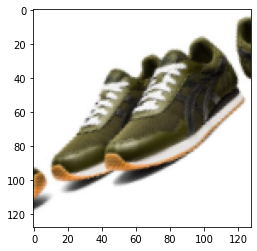

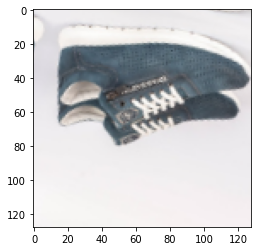

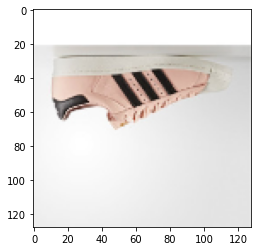

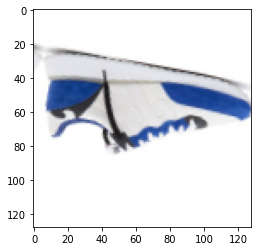

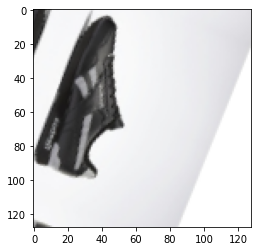

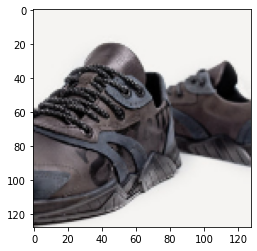

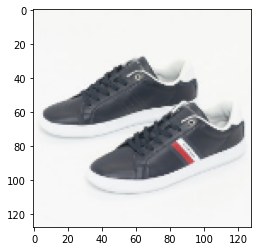

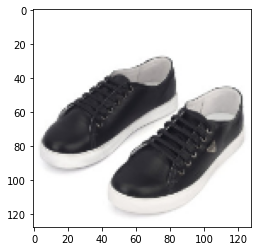

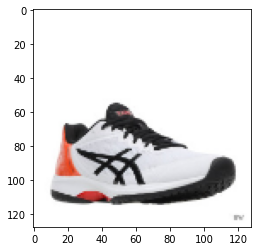

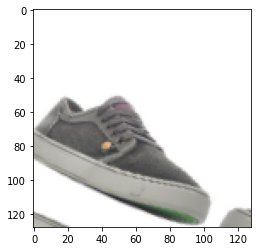

In [ ]:
def show_image(img):
    img = np.transpose(img, (1, 2, 0)).astype(np.float32)
    plt.imshow(img.astype(np.uint8).reshape(128, 128, 3))
    plt.show()

count = 0
for x, y in train_dataloader:
    if count == 10:
        break
    show_image(np.array(x.detach().cpu())[0]* 255)
    count += 1

In [ ]:
vae = setup_model()

In [ ]:
vae = train(vae, train_dataloader, n_epochs = 75)

Training ...


  1%|▏         | 1/75 [01:22<1:41:19, 82.15s/it]

Error on 35385.92998836016 epoch = 0


  3%|▎         | 2/75 [02:44<1:39:44, 81.99s/it]

Error on 17100.56434735813 epoch = 1


  4%|▍         | 3/75 [04:06<1:38:24, 82.00s/it]

Error on 12611.438904288107 epoch = 2


  5%|▌         | 4/75 [05:27<1:36:37, 81.66s/it]

Error on 10949.568169761855 epoch = 3


  7%|▋         | 5/75 [06:48<1:35:00, 81.43s/it]

Error on 9751.061077353395 epoch = 4


  8%|▊         | 6/75 [08:09<1:33:25, 81.24s/it]

Error on 8925.808636358157 epoch = 5


  9%|▉         | 7/75 [09:30<1:32:01, 81.19s/it]

Error on 8303.844759169386 epoch = 6


 11%|█         | 8/75 [10:51<1:30:43, 81.25s/it]

Error on 7912.411390927504 epoch = 7


 12%|█▏        | 9/75 [12:12<1:29:26, 81.31s/it]

Error on 7608.69140145487 epoch = 8


 13%|█▎        | 10/75 [13:34<1:28:10, 81.40s/it]

Error on 7422.453626981622 epoch = 9


 15%|█▍        | 11/75 [14:56<1:26:52, 81.45s/it]

Error on 7251.541669954756 epoch = 10


 16%|█▌        | 12/75 [16:17<1:25:28, 81.41s/it]

Error on 7121.722388681739 epoch = 11


 17%|█▋        | 13/75 [17:38<1:24:05, 81.37s/it]

Error on 6930.400473101238 epoch = 12


 19%|█▊        | 14/75 [19:00<1:22:44, 81.39s/it]

Error on 6831.075863479631 epoch = 13


 20%|██        | 15/75 [20:21<1:21:24, 81.41s/it]

Error on 6728.940536002385 epoch = 14


 21%|██▏       | 16/75 [21:43<1:20:03, 81.41s/it]

Error on 6615.328554917666 epoch = 15


 23%|██▎       | 17/75 [23:04<1:18:42, 81.41s/it]

Error on 6495.168833243459 epoch = 16


 24%|██▍       | 18/75 [24:25<1:17:21, 81.43s/it]

Error on 6462.026204153076 epoch = 17


 25%|██▌       | 19/75 [25:47<1:16:02, 81.48s/it]

Error on 6385.8401969455845 epoch = 18


 27%|██▋       | 20/75 [27:08<1:14:38, 81.43s/it]

Error on 6287.467200487952 epoch = 19


 28%|██▊       | 21/75 [28:30<1:13:13, 81.36s/it]

Error on 6232.260107449276 epoch = 20


 29%|██▉       | 22/75 [29:51<1:11:56, 81.43s/it]

Error on 6155.483898364066 epoch = 21


 31%|███       | 23/75 [31:13<1:10:34, 81.44s/it]

Error on 6082.886114563605 epoch = 22


 32%|███▏      | 24/75 [32:34<1:09:09, 81.36s/it]

Error on 6068.978620432844 epoch = 23


 33%|███▎      | 25/75 [33:55<1:07:45, 81.30s/it]

Error on 5999.336204657249 epoch = 24


 35%|███▍      | 26/75 [35:16<1:06:23, 81.30s/it]

Error on 5966.991573038326 epoch = 25


 36%|███▌      | 27/75 [36:38<1:05:05, 81.36s/it]

Error on 5878.082407188202 epoch = 26


 37%|███▋      | 28/75 [37:59<1:03:48, 81.45s/it]

Error on 5841.326226128473 epoch = 27


 39%|███▊      | 29/75 [39:21<1:02:33, 81.60s/it]

Error on 5831.031224791316 epoch = 28


 40%|████      | 30/75 [40:44<1:01:20, 81.78s/it]

Error on 5768.591552460368 epoch = 29


 41%|████▏     | 31/75 [42:06<1:00:03, 81.90s/it]

Error on 5722.715867578782 epoch = 30


 43%|████▎     | 32/75 [43:28<58:43, 81.94s/it]  

Error on 5703.8360095639555 epoch = 31


 44%|████▍     | 33/75 [44:50<57:24, 82.01s/it]

Error on 5674.527829976194 epoch = 32


 45%|████▌     | 34/75 [46:12<56:03, 82.03s/it]

Error on 5630.365744576845 epoch = 33


 47%|████▋     | 35/75 [47:34<54:43, 82.08s/it]

Error on 5622.285434641554 epoch = 34


 48%|████▊     | 36/75 [48:56<53:22, 82.10s/it]

Error on 5594.736356347766 epoch = 35


 49%|████▉     | 37/75 [50:18<51:58, 82.05s/it]

Error on 5550.477347531302 epoch = 36


 51%|█████     | 38/75 [51:40<50:28, 81.85s/it]

Error on 5537.6783129417 epoch = 37


 52%|█████▏    | 39/75 [53:01<49:02, 81.74s/it]

Error on 5493.390772690008 epoch = 38


 53%|█████▎    | 40/75 [54:23<47:38, 81.69s/it]

Error on 5530.160517117793 epoch = 39


 55%|█████▍    | 41/75 [55:44<46:15, 81.62s/it]

Error on 5426.182923938824 epoch = 40


 56%|█████▌    | 42/75 [57:06<44:52, 81.58s/it]

Error on 5456.60218490789 epoch = 41


 57%|█████▋    | 43/75 [58:27<43:30, 81.57s/it]

Error on 5403.601469885487 epoch = 42


 59%|█████▊    | 44/75 [59:49<42:08, 81.56s/it]

Error on 5415.2075862520605 epoch = 43


 60%|██████    | 45/75 [1:01:10<40:47, 81.59s/it]

Error on 5361.736230304346 epoch = 44


 61%|██████▏   | 46/75 [1:02:32<39:26, 81.60s/it]

Error on 5340.951486983551 epoch = 45


 63%|██████▎   | 47/75 [1:03:54<38:03, 81.56s/it]

Error on 5330.26080260614 epoch = 46


 64%|██████▍   | 48/75 [1:05:15<36:42, 81.57s/it]

Error on 5297.769202989092 epoch = 47


 65%|██████▌   | 49/75 [1:06:37<35:21, 81.59s/it]

Error on 5342.7498335404825 epoch = 48


 67%|██████▋   | 50/75 [1:07:58<33:58, 81.53s/it]

Error on 5299.409067481455 epoch = 49


 68%|██████▊   | 51/75 [1:09:19<32:35, 81.46s/it]

Error on 5241.053182240154 epoch = 50


 69%|██████▉   | 52/75 [1:10:41<31:13, 81.46s/it]

Error on 5267.872069216471 epoch = 51


 71%|███████   | 53/75 [1:12:02<29:50, 81.40s/it]

Error on 5247.966094593943 epoch = 52


 72%|███████▏  | 54/75 [1:13:23<28:27, 81.32s/it]

Error on 5222.785284211473 epoch = 53


 73%|███████▎  | 55/75 [1:14:45<27:08, 81.40s/it]

Error on 5215.790140993266 epoch = 54


 75%|███████▍  | 56/75 [1:16:07<25:47, 81.47s/it]

Error on 5184.190930025077 epoch = 55


 76%|███████▌  | 57/75 [1:17:28<24:26, 81.45s/it]

Error on 5183.67683261653 epoch = 56


 77%|███████▋  | 58/75 [1:18:49<23:03, 81.41s/it]

Error on 5170.114023536143 epoch = 57


 79%|███████▊  | 59/75 [1:20:10<21:41, 81.32s/it]

Error on 5145.418275638328 epoch = 58


 80%|████████  | 60/75 [1:21:32<20:18, 81.26s/it]

Error on 5156.359178810676 epoch = 59


 81%|████████▏ | 61/75 [1:22:53<18:57, 81.27s/it]

Error on 5134.066541609674 epoch = 60


 83%|████████▎ | 62/75 [1:24:14<17:35, 81.18s/it]

Error on 5101.599432503201 epoch = 61


 84%|████████▍ | 63/75 [1:25:35<16:13, 81.16s/it]

Error on 5099.4324933361395 epoch = 62


 85%|████████▌ | 64/75 [1:26:56<14:53, 81.22s/it]

Error on 5109.606843993319 epoch = 63


 87%|████████▋ | 65/75 [1:28:17<13:31, 81.18s/it]

Error on 5043.392024218969 epoch = 64


 88%|████████▊ | 66/75 [1:29:38<12:09, 81.06s/it]

Error on 5061.604487118362 epoch = 65


 89%|████████▉ | 67/75 [1:30:59<10:47, 81.00s/it]

Error on 5074.725393310273 epoch = 66


 91%|█████████ | 68/75 [1:32:20<09:27, 81.03s/it]

Error on 5050.374423488356 epoch = 67


 92%|█████████▏| 69/75 [1:33:41<08:06, 81.01s/it]

Error on 5050.992760997562 epoch = 68


 93%|█████████▎| 70/75 [1:35:02<06:45, 81.05s/it]

Error on 5031.98340323263 epoch = 69


 95%|█████████▍| 71/75 [1:36:23<05:24, 81.04s/it]

Error on 5010.634469011951 epoch = 70


 96%|█████████▌| 72/75 [1:37:45<04:03, 81.20s/it]

Error on 5015.236519519193 epoch = 71


 97%|█████████▋| 73/75 [1:39:06<02:42, 81.29s/it]

Error on 4998.570273590944 epoch = 72


 99%|█████████▊| 74/75 [1:40:28<01:21, 81.28s/it]

Error on 4998.891164383636 epoch = 73


100%|██████████| 75/75 [1:41:49<00:00, 81.46s/it]

Error on 4975.801582995756 epoch = 74
Epoch [75 / 75] average reconstruction error: 6539.107133


In [ ]:
vae = train(vae, train_dataloader, n_epochs = 20)

Training ...


  5%|▌         | 1/20 [01:21<25:54, 81.81s/it]

Error on 5023.110601868292 epoch = 0


 10%|█         | 2/20 [02:43<24:34, 81.90s/it]

Error on 4976.541695711455 epoch = 1


 15%|█▌        | 3/20 [04:05<23:11, 81.87s/it]

Error on 4938.774662313236 epoch = 2


 20%|██        | 4/20 [05:27<21:47, 81.75s/it]

Error on 4954.9084121926735 epoch = 3


 25%|██▌       | 5/20 [06:48<20:26, 81.73s/it]

Error on 4930.942770670025 epoch = 4


 30%|███       | 6/20 [08:10<19:03, 81.70s/it]

Error on 4932.386880414387 epoch = 5


 35%|███▌      | 7/20 [09:32<17:42, 81.72s/it]

Error on 4929.239189447645 epoch = 6


 40%|████      | 8/20 [10:54<16:22, 81.84s/it]

Error on 4923.5464996098135 epoch = 7


 45%|████▌     | 9/20 [12:16<15:00, 81.83s/it]

Error on 4933.155591286125 epoch = 8


 50%|█████     | 10/20 [13:38<13:38, 81.83s/it]

Error on 4964.57434588945 epoch = 9


 55%|█████▌    | 11/20 [14:59<12:15, 81.74s/it]

Error on 4905.935310132576 epoch = 10


 60%|██████    | 12/20 [16:20<10:53, 81.64s/it]

Error on 4889.331895890326 epoch = 11


 65%|██████▌   | 13/20 [17:42<09:30, 81.57s/it]

Error on 4896.233994951687 epoch = 12


 70%|███████   | 14/20 [19:04<08:09, 81.61s/it]

Error on 4868.2385329258295 epoch = 13


 75%|███████▌  | 15/20 [20:25<06:48, 81.67s/it]

Error on 4888.721676947425 epoch = 14


 80%|████████  | 16/20 [21:47<05:26, 81.75s/it]

Error on 4864.5585051085945 epoch = 15


 85%|████████▌ | 17/20 [23:09<04:05, 81.75s/it]

Error on 4843.599177128271 epoch = 16


 90%|█████████ | 18/20 [24:31<02:43, 81.71s/it]

Error on 4874.816726016677 epoch = 17


 95%|█████████▌| 19/20 [25:53<01:21, 81.77s/it]

Error on 4856.043461415369 epoch = 18


100%|██████████| 20/20 [27:14<00:00, 81.74s/it]

Error on 4831.168575402462 epoch = 19
Epoch [20 / 20] average reconstruction error: 4911.291425


In [ ]:
torch.save(vae, './vae_model_torch.pth')

In [ ]:
test_dataloader = DataLoader(MyDataset('/content/KedyKrossy', None, flag_train = False), batch_size = 2, shuffle=True)

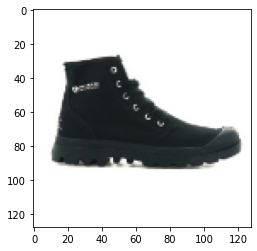

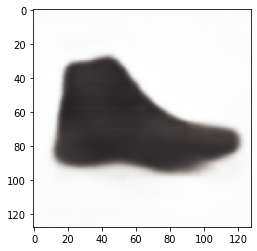

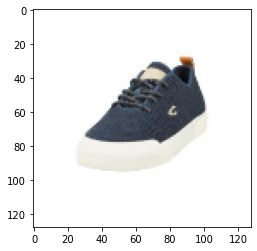

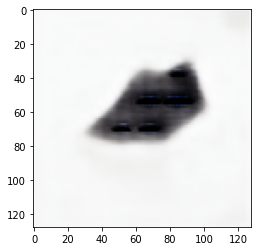

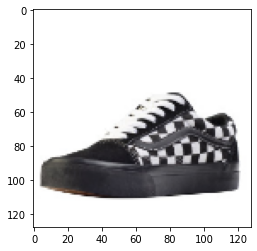

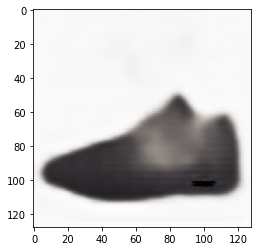

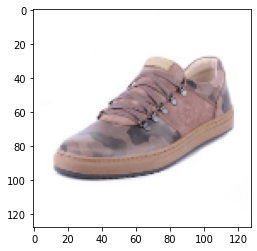

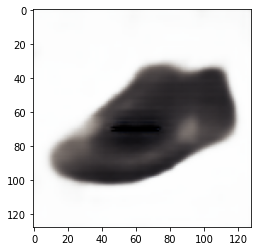

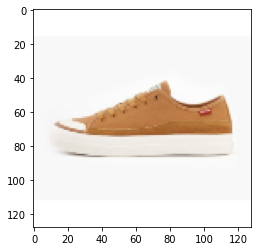

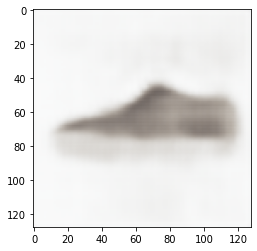

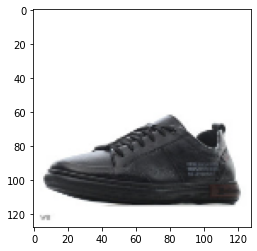

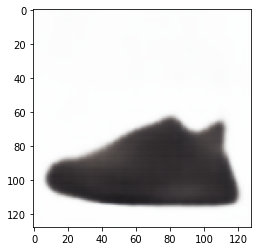

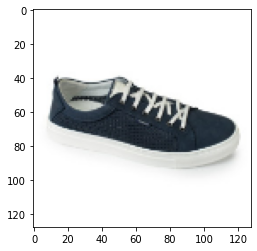

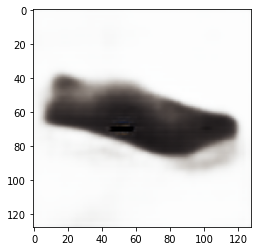

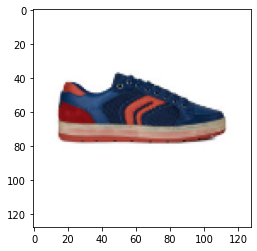

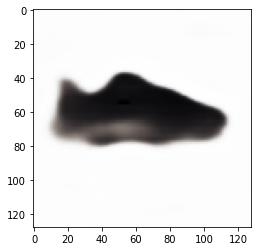

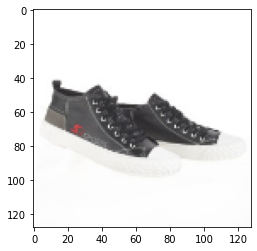

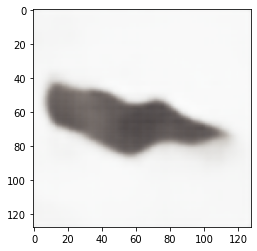

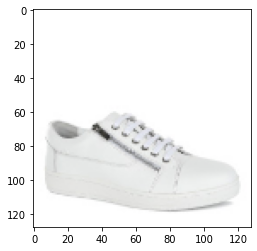

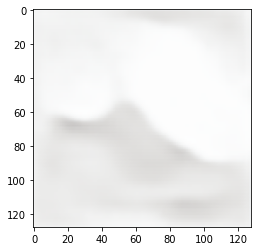

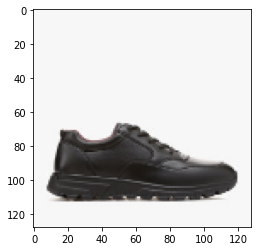

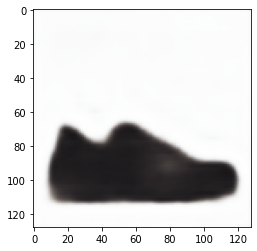

In [ ]:
def show_image(img):
    img = np.transpose(img, (1, 2, 0)).astype(np.float32)
    plt.imshow(img.astype(np.uint8).reshape(128, 128, 3))
    plt.show()

count = 0
for x, _ in test_dataloader:
    x = x.to(device='cuda')
    pred, _, _ = vae(x)
    show_image(np.array(x.detach().cpu())[0] * 255)
    show_image(np.array(pred.detach().cpu())[0] * 255)

    if count == 10:
        break
    count += 1